<a href="https://colab.research.google.com/github/saikrithik/Jovian-Course-Pytorch-DeepLearning/blob/main/Assignment_04_Course_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1h2ZZq_Tz_ltfKnCZEwBG0Qw5I1kHLoiM')

In [11]:
!nvidia-smi

Sun Jan 10 02:33:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
!pip install jovian --upgrade --quiet

# Course PROJECT
##### [Game of Deep Learning: Computer Vision Hackathon](https://datahack.analyticsvidhya.com/contest/game-of-deep-learning)

Ship or vessel detection has a wide range of applications, in the areas of maritime safety,  fisheries management, marine pollution, defence and maritime security, protection from piracy, illegal migration, etc. Keeping this in mind, a Governmental Maritime and Coastguard Agency is planning to deploy a computer vision based automated system to identify ship type only from the images taken by the survey boats. You have been hired as a consultant to build an efficient model for this project. There are 5 classes of ships to be detected which are as follows:

![](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/05/Screenshot-2019-05-23-at-2.54.19-PM.png)

## Dataset Description
There are 6252 images in train and 2680 images in test data. The categories of ships and their corresponding codes in the dataset are as follows - \
{ 'Cargo': 1, \
'Military': 2, \
'Carrier': 3, \
'Cruise': 4, \
'Tankers': 5 }
- There are three files provided to you, viz train.zip, test.csv and sample_submission.csv which have the following structure.

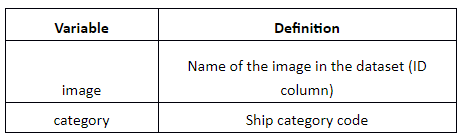

- train.zip contains the images corresponding to both train and test set along with the true labels for train set images in train.csv

## Evaluation Metric
The Evaluation metric for this competition is weighted F1 Score.

## Public and Private Split
Public leaderboard is based on randomly selected 30% of the test images, while private leaderboard will be evaluated on remaining 70% of the test images.



In [13]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [14]:
project_name='course-project-01'

## Downloading Data

In [15]:
!gdown --id 1NtTtrudF4MBAVc8mMF8qUmu36OEbgqRJ

Downloading...
From: https://drive.google.com/uc?id=1NtTtrudF4MBAVc8mMF8qUmu36OEbgqRJ
To: /content/course-project-01.rar
171MB [00:02, 64.7MB/s]


## Setting up our Data

In [ ]:
try:
    os.makedirs("my-course-project")
except FileExistsError:
    pass

if len(os.listdir('/content/my-course-project'))==0:
  !unrar x "/content/course-project-01.rar" "/content/my-course-project" 
else:
  print("Already Unzipped")

try:
    os.makedirs("dataset")
except FileExistsError:
    pass
#--------------------------------
try:
    os.makedirs("/content/dataset/train")
except FileExistsError:
    pass
try:
    os.makedirs("/content/dataset/test")
except FileExistsError:
    pass
#---------------------------------
import pandas as pd
train = pd.read_csv("/content/my-course-project/train/train.csv")
test = pd.read_csv("/content/my-course-project/test_ApKoW4T.csv")
for i in train.category.unique():
  try:
    os.mkdir("/content/dataset/train/"+str(i))
  except FileExistsError:
    pass

#### Copying files because of the data leak between train and test

In [17]:
import shutil
for iter,image in enumerate(train["image"]):
  shutil.copyfile("/content/my-course-project/train/images/"+image,
              "/content/dataset/train/"+str(train["category"][iter])+"/"+image)
for iter,image in enumerate(test["image"]):
  shutil.copyfile("/content/my-course-project/train/images/"+image,
              "/content/dataset/test/"+image)

In [18]:
# Look into the data directory
data_dir = '/content/dataset'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['4', '5', '2', '3', '1']


In [19]:
import cv2
imagesdf= []
for i in os.listdir('/content/my-course-project/train/images'):
  img = cv2.imread("/content/my-course-project/train/images/"+str(i),1)
  resized_image = cv2.resize(img, (200, 300))
  imagesdf.append(resized_image)
imagesdf = np.array(imagesdf).reshape(8932,3,300,200)

In [20]:
# red_mean = imagesdf[:,0].mean()/255
# blue_mean = imagesdf[:,1].mean()/255
# green_mean = imagesdf[:,2].mean()/255
# red_std = imagesdf[:,0].std()/255
# blue_std = imagesdf[:,1].std()/255
# green_std = imagesdf[:,2].std()/255
# # Data transforms (normalization & data augmentation)
# stats = ((red_mean, blue_mean, green_mean), (red_std, blue_std, green_std))

In [21]:
data_dir = '/content/dataset'
transformations = tt.Compose([
    tt.Resize((256,384),interpolation=2),
    tt.ToTensor(),
    # tt.Normalize(*stats,inplace=True)
])
dataset = ImageFolder(data_dir+'/train', transform = transformations)
len(dataset)

6252

In [22]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  1 (0)


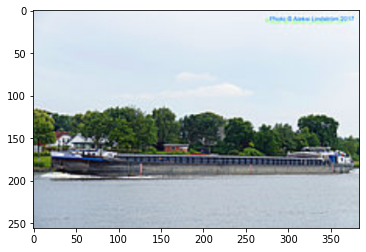

In [23]:
show_example(*dataset[1200])

Label:  1 (0)


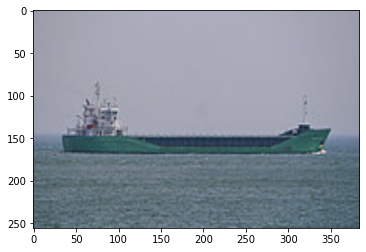

In [24]:
show_example(*dataset[1220])

In [25]:
random_seed = 42
torch.manual_seed(random_seed);

In [26]:
val_size = 600
train_size = len(dataset) - val_size
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(5652, 600)

In [27]:
# def class_counter(class_dict,num):
#   class_dict[num] = class_dict[num] +1
#   return class_dict

# class_dict = {0:0,1:0,2:0,3:0,4:0}
# for _,class_num in train_ds:
#   class_dict = class_counter(class_dict,class_num)
# factor=1.0/sum(class_dict.values())
# for k in class_dict:
#   class_dict[k] = class_dict[k]*factor
# class_dict

In [28]:
# class_dict = {0:0,1:0,2:0,3:0,4:0}
# for _,class_num in valid_ds:
#   class_dict = class_counter(class_dict,class_num)
# factor=1.0/sum(class_dict.values())
# for k in class_dict:
#   class_dict[k] = class_dict[k]*factor
# class_dict

In [29]:

train_tfms = tt.Compose([tt.RandomCrop(200, padding=4), 
                         tt.RandomHorizontalFlip(),
                         tt.Resize((255,255),interpolation=2),
                         # tt.RandomRotate
                        #  tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                        #  tt.Normalize(*stats,inplace=True),
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),]) 
                        
valid_tfms = tt.Compose([tt.ToTensor(),
                        #  tt.Normalize(*stats),
                         tt.Resize((255,255),interpolation=2),])

In [30]:
# transorms
train_ds.transforms = train_tfms
valid_ds.transforms = valid_tfms

In [31]:
batch_size = 32
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3,
                      pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=3, pin_memory=True)

In [32]:
for index,(img,label) in enumerate(valid_dl):
  if index == 2:
    print(img.shape)
    print(label)
    break

torch.Size([32, 3, 256, 384])
tensor([0, 0, 3, 1, 1, 4, 4, 4, 0, 0, 4, 2, 0, 3, 4, 2, 0, 0, 0, 2, 3, 1, 2, 4,
        0, 4, 3, 1, 0, 2, 2, 4])


### Using a GPU


In [33]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [34]:
device = get_default_device()
device

device(type='cuda')

In [35]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [36]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Defining our Model Architecture 

In [37]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet12(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #3, 256, 384
        self.conv1 = conv_block(in_channels, 16)#(16,256,384) 
        self.conv2 = conv_block(16, 32, pool=True)#(32,128,192) 
        self.res1 = nn.Sequential(conv_block(32, 32), conv_block(32, 32))#(32,128,192) 
        
        self.conv3 = conv_block(32, 64, pool=True)#(64,64,96) 
        self.conv4 = conv_block(64, 128, pool=True)#(128,32,48) 
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))#(128,32,48) 

        self.conv5 = conv_block(128, 192, pool=True)#(192,16,24) 
        self.conv6 = conv_block(192, 256, pool=True)#(256,8,12) 
        self.res3 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2),#(256,4,6) 
                                        nn.Flatten(), 
                                        nn.Dropout(0.5), 
                                        nn.Linear(256*4*6, 256),
                                        nn.Dropout(0.3),
                                        nn.Linear(256, num_classes)) 
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

In [38]:
model = to_device(ResNet12(3, 5), device)
model

ResNet12(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
   

In [39]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Validating with Randomly allocated weights

In [40]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.21655699610710144, 'val_loss': 1.6083157062530518}]

### Training our Model

In [41]:
epochs = 40
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam
history=[]

In [42]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00045, train_loss: 2.3002, val_loss: 1.6543, val_acc: 0.4342
Epoch [1], last_lr: 0.00083, train_loss: 1.9985, val_loss: 2.7964, val_acc: 0.4370
Epoch [2], last_lr: 0.00144, train_loss: 1.7014, val_loss: 1.6238, val_acc: 0.4572
Epoch [3], last_lr: 0.00224, train_loss: 1.6031, val_loss: 5.2608, val_acc: 0.3531
Epoch [4], last_lr: 0.00316, train_loss: 1.7859, val_loss: 2.9018, val_acc: 0.4775
Epoch [5], last_lr: 0.00416, train_loss: 1.3410, val_loss: 5.9445, val_acc: 0.4934
Epoch [6], last_lr: 0.00515, train_loss: 0.9608, val_loss: 0.8252, val_acc: 0.6639
Epoch [7], last_lr: 0.00608, train_loss: 0.8545, val_loss: 0.7763, val_acc: 0.6853
Epoch [8], last_lr: 0.00687, train_loss: 0.7660, val_loss: 0.8037, val_acc: 0.6310
Epoch [9], last_lr: 0.00749, train_loss: 0.7435, val_loss: 0.7552, val_acc: 0.7018
Epoch [10], last_lr: 0.00787, train_loss: 0.6851, val_loss: 0.6429, val_acc: 0.7215
Epoch [11], last_lr: 0.00800, train_loss: 0.7517, val_loss: 1.3001, val_acc: 0.4874
Ep

#### 86 % Accuracy in the valset resulted in 91 % F1 score in the private leaderboard!

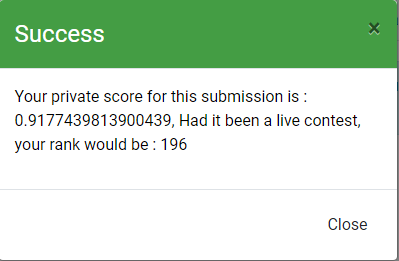

In [43]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

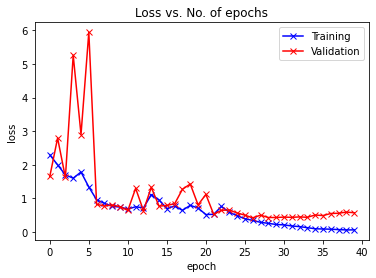

In [44]:
plot_losses(history)

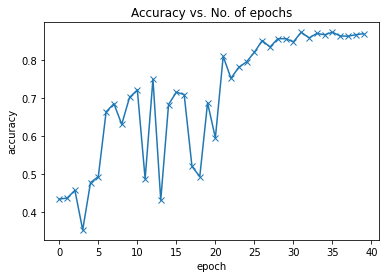

In [45]:
plot_accuracies(history)

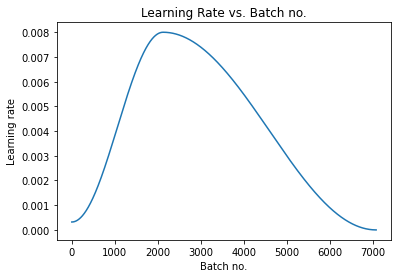

In [46]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [47]:
torch.save(model.state_dict(), 'project-resnet12-updated.pth')

In [48]:
# model2 = to_device(ResNet12(), device)
# model2.load_state_dict(torch.load('project-resnet12-updated.pth'))

In [49]:
test

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg
...,...
2675,950995.jpg
2676,951046.jpg
2677,951323.jpg
2678,952113.jpg


## Predicting on Unseen Test Data

In [50]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [51]:
dataset.classes

['1', '2', '3', '4', '5']

In [52]:
%%time
from PIL import Image
test_images = []
predictions = []
for iter,i in enumerate(test["image"]):
  image = Image.open(data_dir+"/test/"+str(i),mode='r').convert('RGB')  
  input = transformations(image)
  pred = predict_image(input, model)
  predictions.append(pred)

CPU times: user 14.3 s, sys: 348 ms, total: 14.6 s
Wall time: 14.6 s


In [53]:
input.shape

torch.Size([3, 256, 384])

In [54]:
sub = pd.read_csv("/content/my-course-project/sample_submission_ns2btKE.csv")

In [55]:
sub["category"] = predictions
sub["category"] = sub["category"].astype(int)

### Getting the Predictions in to a CSV

In [56]:
sub.to_csv("output.csv",index=False)

In [57]:
sub.category.value_counts(normalize=True)

1    0.355224
2    0.188433
5    0.181343
3    0.143657
4    0.131343
Name: category, dtype: float64

In [58]:
train.category.value_counts(normalize=True)

1    0.339091
5    0.194658
2    0.186660
3    0.146513
4    0.133077
Name: category, dtype: float64

## Commit

In [59]:
arch = "ResNet12 with D = 1 ( 3 residual Layers with 2 layer-->(256,8,12)  Feed-Forward-NN(droputs - 0.5,0.3)"
lrs = max_lr
test_loss = [x['val_loss'] for x in history][-1]
test_acc = [x['val_acc'] for x in history][-1]

In [62]:
jovian.log_hyperparams(arch=arch, 
                       lrs=lrs, 
                       epochs=epochs)
jovian.log_metrics(test_loss=test_loss, test_acc=test_acc)

[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [63]:
jovian.commit(project=project_name, environment=None, outputs=['project-resnet12-updated.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/saikrithik/course-project-01


'https://jovian.ai/saikrithik/course-project-01'